In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [1]:
%pip install -qq -U datasets transformers pyarrow
%pip install -qq --upgrade transformers ftfy accelerate regex tqdm
%pip install git+https://github.com/openai/CLIP.git

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cuml 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.7 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 14.0.2 which is incompatible.
beatrix-jupyterlab 2023.814.150030 requires jupyter-server~=1.16, but you have jupyter-server 2.12.1 which is incompatible.
beatrix-jupyterlab 2023.814.150030 requires jupyterlab~=3.4, but you have jupyterlab 4.0.5 which is incompatible.
cudf 23.8.0 requires pandas<1.6.0dev0,>=1.3, but you have pandas 2.0.3 which is incompatible.
cudf 23.8.0 requires protobuf<5,>=4.21, but you have protobuf 3.20.3 which is incompati

Let's import all the libraries we need

In [7]:
import clip
import os
import torch
import requests
import json
import pickle

from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from PIL import Image
from datasets import load_dataset
from pathlib import Path
from random import shuffle


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device set to {device}")

Device set to cuda


**Download the CLIP model to encode the image**

In [4]:
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)


100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 193MiB/s]


**Let's Write a method to encode the image using clip model**

In [5]:
def calc_image_emb(img, model, preprocess, device):
    """
    This method computes the clip embeddings for a given image, after preprocessing it according to the model
    """
    image = preprocess(img).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = model.encode_image(image)
    return image_features
    


In [ ]:

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
img_features = calc_image_emb(image, clip_model, clip_preprocess, device)
print(img_features)

In [ ]:
cc = img_features.squeeze().tolist()
print(len(cc))
print(cc[0])

In [ ]:
#dataset = load_dataset("json", data_files="llava_instruct_150k.json")
dataset = load_dataset("liuhaotian/LLaVA-Instruct-150K", data_files='llava_instruct_150k.json', split='train')


In [ ]:
eg = next(iter(dataset))
print(eg)

**We need to download COCO2017 images, and compute the CLIP embeddings and store them first**

In [45]:
def prepare_image_embeddings(img_path_list, root_dir = None):
    """
    This method computes the CLIP image embeddings for all the images in COCO 2017 dataset
    """
    embeddings_dict = {}
    for f_name in tqdm(img_path_list):
        if root_dir is not None:
            f_name = os.path.join(root_dir, f_name)
        img = Image.open(f_name)
        f_base = Path(f_name).stem
        img_embd = calc_image_emb(img, clip_model, clip_preprocess, device)
        embeddings_dict[f_base] = img_embd.squeeze().tolist()
    return embeddings_dict

def get_absolute_paths(directory_path, max_files = None):
    absolute_paths = []

    # Check if the given path is a valid directory
    if os.path.isdir(directory_path):
        # Iterate over all files in the directory
        for root, _, files in tqdm(os.walk(directory_path)):
            for file in files:
                # Construct the absolute path for each file
                absolute_path = os.path.abspath(os.path.join(root, file))
                absolute_paths.append(absolute_path)
                if max_files is not None and len(absolute_paths) > max_files:
                    break
    return absolute_paths

def prepare_files_list(dataset_path, dirs = None):
    files_list = []
    for each_dir in dirs:
        files_list.extend(get_absolute_paths(os.path.join(dataset_path, each_dir)))
    return files_list


def write_dict_to_json(data_dict, file_path):
    """
    Write a dictionary to a JSON file.

    Parameters:
    - dictionary: The dictionary to be written to the file.
    - file_path: The path to the JSON file.
    """
    with open(file_path, 'w') as json_file:
        json.dump(data_dict, json_file, indent=4)
        

def read_json_file(file_path):
    """
    Read a JSON file and return its contents as a dictionary.

    Parameters:
    - file_path (str): The path to the JSON file.

    Returns:
    - dict: The contents of the JSON file as a dictionary.
    """
    try:
        with open(file_path, 'r') as file:
            data = json.load(file)
            return data
    except FileNotFoundError:
        print(f"Error: File not found - {file_path}")
    except json.JSONDecodeError:
        print(f"Error: Unable to decode JSON in file - {file_path}")

        
def list_of_dicts_to_dict_of_dicts(list_of_dicts, key):
    """
    Convert a list of dictionaries to a dictionary of dictionaries using a specified key.

    Parameters:
    - list_of_dicts (list): A list of dictionaries.
    - key (str): The key to use as the identifier.

    Returns:
    - dict: A dictionary of dictionaries with the specified key.
    """
    result_dict = {}

    for item in list_of_dicts:
        identifier = item.get(key)
        if identifier is not None:
            result_dict[identifier] = item

    return result_dict

def parse_metadata(metadata_path, dict_key = 'id' ):
    """
    first read json file, then convert to dict
    """
    metadata = read_json_file(metadata_path)
    metadata_dict = list_of_dicts_to_dict_of_dicts(metadata, key = dict_key)
    return metadata_dict

**Load embeddings for COCO dataset. If embeddings are not available, prepare the same**

In [ ]:
pkl_file_path = '/kaggle/working/coco_embeddings.pkl'
json_file_path = '/kaggle/working/coco_embeddings.json'

if os.path.exists(pkl_file_path) or os.path.exists(json_file_path):
    embeddings_available = True
else:
    embeddings_available = False

In [ ]:
if not embeddings_available: 
    dataset_path = '/kaggle/input/coco-2017-dataset/coco2017'
    files_list = prepare_files_list(dataset_path)
    embeddings_dict = prepare_image_embeddings(files_list)

    # Write to pkl file
    with open(pkl_file_path,'wb') as fh:
        pickle.dump(embeddings_dict, fh)

    # Write to JSON
    write_dict_to_json(embeddings_dict_list2, json_file_path)

**Compute CLIP embeddings for CC3M dataset (https://huggingface.co/datasets/liuhaotian/LLaVA-CC3M-Pretrain-595K)**

**First load the metadata file for captions**

In [53]:
json_file_path = '/kaggle/input/cc3m-captions/metadata.json'
metadata_key = 'id'
cc3m_metadata = parse_metadata(json_file_path, dict_key = metadata_key)

**Gather the list of images in our dataset**

In [56]:
cc3m_path = '/kaggle/input/cc3m-pretrain'
files_list = os.listdir(cc3m_path)
shuffle(files_list)
max_images = 175000
files_list = files_list[:max_images]


**Calculate clip embeddings for all the images**

In [57]:
embedding_dict = prepare_image_embeddings(files_list, root_dir = cc3m_path)

  0%|          | 0/175000 [00:00<?, ?it/s]

In [ ]:
embedding_dict

In [65]:
def update_captions_metadata_with_embeddings(cc3m_metadata, embedding_dict):
    cc3m_metadata_updated = {}
    for key,embedding in tqdm(embedding_dict.items()):
        cc3m_metadata_updated[key] = {
            'clip_embeddings': embedding,
            'id': key,
            'caption': cc3m_metadata[key]['caption'],
            'blip_caption': cc3m_metadata[key]['blip_caption']
        }
    return cc3m_metadata_updated


In [51]:
all_keys = list(metadata.keys())
print(all_keys[0])
metadata[all_keys[0]]

GCC_train_002582585


{'id': 'GCC_train_002582585',
 'image': 'GCC_train_002582585.jpg',
 'caption': 'olive oil is a healthy ingredient used liberally .',
 'blip_caption': 'some olive oil and salt in a glass bottle',
 'url': 'https://i.pinimg.com/736x/de/13/3a/de133a155c777a9db265bb3e7888719d--colombo-olive-oils.jpg'}

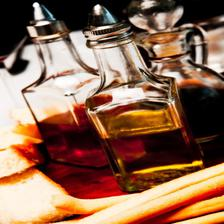

In [52]:
im = Image.open('/kaggle/input/cc3m-pretrain/GCC_train_002582585.jpg')
im

In [66]:
updated_metadata = update_captions_metadata_with_embeddings(cc3m_metadata, embedding_dict)

  0%|          | 0/175000 [00:00<?, ?it/s]

**write updated metadata to json**

In [69]:
# Write to JSON
cc3m_metadata_path = 'cc3m_captions_and_clip_embeddings.json'
write_dict_to_json(updated_metadata, cc3m_metadata_path)

**Write updated metadata to pickle**

In [71]:
# Write to pkl file
pkl_file_path = 'cc3m_captions_and_clip_embeddings.pkl'
with open(pkl_file_path,'wb') as fh:
    pickle.dump(updated_metadata, fh)